# CS436 PA1 Image Warping

Run the following cell, in order to mount your drive with this notebook.

from google.colab import drive
drive.mount('/content/drive')

# Importing Libraries

This might take a few seconds. If any library is missing, make sure to install it in your environment, using anaconda in for library installation is usually easier

In [1]:
import matplotlib
import cv2
import imageio
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
%matplotlib inline
import math as m
import seaborn as sns
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

# 1. Image Warping

In this section, <b>you are not allowed to use any OpenCV functions.</b> OpenCV comes in the next section

## Task 1.1 - Part A (Projective Transformations)


In this section you will be creating a function `warpPerspective(img,M,(cols,rows))`. 
The function performs a projective transformation on an image and returns a new image variable
    
    This function has the following arguments:
        img: original image variable. This can be a black and white or a color image
        M: a 3x3 projective transformation matrix
        cols: the columns of the output image
        rows: the rows of the output matrix        

The function can transform a small image to a larger image. While doing so, the new image must not have any fringes or emply pixels, you can fill those pixels by taking the value of the nearest neigbouring pixel. The pixels outside of an image may be set to black for now. You may change the arguments of the function if you want to add additional features

## Task 1.1 - Part B: Rotation



In this test case, we will be rotating a subsection of an image of a cat. We will convert `cat.jpg` to `cat_sol0_1.jpg`



We can utilize your newly made function for that with the following steps

1. Read the file `part1/cat.jpg`
2. Crop it to the portion that shows just the head
3. Input it to your function with your projective matrix
4. Display the output
5. You can adjust the row and col values such that the entirety of the output image is shown
    
The output should look similar to `part1/cat_sol0_1.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those

In [2]:
def homogenous(x, y):
    coords = np.indices((x, y)).reshape(2, -1)
    return np.vstack((coords, np.ones(coords.shape[1])))
def rot(theta):
    theta = theta
    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta),  np.cos(theta), 0],[0, 0, 1]])
def trans(tx, ty):
    return np.array([[1, 0, tx],[0, 1, ty],[0, 0, 1]])
def scale(x,y):
    x,y = x,y
    return np.array([[x, 0, 0],[0, y, 0],[0, 0, 1]])
def shear(x):
    x = x
    return np.array([[1,0 , 0],[x, 1, 0],[0, 0, 1]])

In [7]:
def warpPerspective(img,M,dsize,linear_inter = False):
    height, width = img.shape[:2]
    tx, ty = np.array((width // 2, height // 2))
    T1 = trans(-tx,-ty)
    T1Inv = np.linalg.inv(T1)
    R1 = M
    S = scale(3,3)
    
    A = np.dot(T1Inv,np.dot(R1,np.dot(S,T1)))

    coords = homogenous(width,height)
    x_ori = coords[0].astype(np.int)

    y_ori = coords[1].astype(np.int)

    warped = np.dot(A,coords)

    x_warped = warped[0,:].reshape(1,-1)
    y_warped= warped[1,:].reshape(1,-1)
    x_min = np.min(x_warped)
    y_min = np.min(y_warped)
    if x_min >=0:
        x_min = 0
    if y_min >=0:
        y_min = 0

    T2 = np.linalg.inv(trans(x_min,y_min))
    warped = np.dot(T2,warped).astype(np.int)
    x_warped = warped[0,:]
    y_warped= warped[1,:]
    x_warped = list(np.ceil(x_warped).astype(np.int))
    y_warped = list(np.ceil(y_warped).astype(np.int))

    final = np.zeros([dsize[0],dsize[1],3],dtype=np.int)
    
    
    warped = np.vstack((x_warped,y_warped)).astype(np.int)
    coords2 = np.vstack((coords[0],coords[1])).astype(np.int)
    for i in range(coords2.shape[1]):
        x_from,y_from = coords2[:,i]
        x_to,y_to = warped[:,i]
        rgb_from = img[x_from,y_from]
        final[x_to,y_to] = rgb_from 
        
        
    #Filling missing values
    
    final_homo = homogenous(dsize[0],dsize[1])
    final_homo = np.array(final_homo[0:2,:])
    
    min_x = np.min(warped[0])
    max_x = np.max(warped[0])
    min_y = np.min(warped[1])
    max_y = np.max(warped[1])
    
    
    if linear_inter == False:
        for i in range(final_homo.shape[1]):
            x,y = final_homo[:,i].astype(np.int)
            rgb = final[x,y]
            t_c = 0
            
            rgb_this = np.zeros_like(rgb)
            if rgb[0] == 0 and rgb[1] == 0 and rgb[2] == 0:
                if((x <= min_x or x >= max_x) or (y <= min_y or y >= max_y )):
                    continue
                else:
                    rgb_avg = np.zeros_like(rgb)
                
                    temp_warped = np.array((warped[0] == x))
                    all_x =warped[:,temp_warped]
                    if all_x.size == 0:    
                        continue
                        
                    minn_y = np.min(all_x[1])
                    maxx_y = np.max(all_x[1])
                    if y <= minn_y:
                        continue
                    elif y >= maxx_y:
                        continue
                    else:
                        
                        if (y <= (max_y) and (x <= (max_x)) and (x > 0) and (y > 0)):
                           
                            if final[x+1,y+1][0] != 0 and final[x+1,y+1][1] != 0 and final[x+1,y+1][2] != 0:
                                t_c+=1
                                rgb_this = final[x+1,y+1]

                            if final[x-1,y-1][0] != 0 and final[x-1,y-1][1] != 0 and final[x-1,y-1][2] != 0:
                                t_c+=1
                                rgb_this = final[x-1,y-1]     

                            if final[x-1,y][0] != 0 and final[x-1,y][1] != 0 and final[x-1,y][2] != 0:
                                t_c+=1
                                rgb_this = final[x-1,y]

                            if final[x,y-1][0] != 0 and final[x,y-1][1] != 0 and final[x,y-1][2] != 0:
                                t_c+=1
                                rgb_this = final[x,y-1]

                            if final[x+1,y][0] != 0 and final[x+1,y][1] != 0 and final[x+1,y][2] != 0:
                                t_c+=1
                                rgb_this = final[x+1,y]    
                            if final[x,y+1][0] != 0 and final[x,y+1][1] != 0 and final[x,y+1][2] != 0:
                                t_c+=1
                                rgb_this = final[x,y+1]

                            if t_c != 0:
                                final[x,y] = rgb_this
                                                    
                                                    
            
    elif linear_inter == True:    
        for i in range(final_homo.shape[1]):
            x,y = final_homo[:,i].astype(np.int)
            rgb = final[x,y]
            
            t_c_r,t_c_g,t_c_b = 0,0,0
            if rgb[0] == 0 and rgb[1] == 0 and rgb[2]  == 0:
                if((x < min_x or x > max_x) or (y < min_y or y > max_y )):
                    continue
                else:
                    rgb_avg = np.zeros_like(rgb)
                
                    temp_warped = np.array((warped[0] == x))
                    all_x =warped[:,temp_warped]
                    if all_x.size == 0:    
                        continue
                        
                    minn_y = np.min(all_x[1])
                    maxx_y = np.max(all_x[1])
                    if y < minn_y:
                        continue
                    elif y > maxx_y:
                        continue
                    else:
                        if ((x > min_x and y> min_y) & (x< (max_x)) and (y < (max_y))): 
                            xx,yy = x-1, y-1
                            for i in range(3):
                                for j in range(3):
                                    rgb_check = final[xx+i,yy+j]
                                    if rgb_check[0] >= 1:
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                        
                                    if rgb_check[1] >= 1:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 1:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            
                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2] 
                                
                        elif (x == 0 and y == 0):
                            xx, yy = x,y
                            for i in range(2):
                                for j in range(2):
                                    rgb_check = final[xx+i,yy+j]
                                    if rgb_check[0] >= 1:
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                    if rgb_check[1] >= 1:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 1:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]           

                        
                        
                        elif (x > min_x and (x < max_x) and y == min_y ):
                            
                            xx, yy = x,y-1
                            for i in range(3):
                                for j in range(3):

                                    rgb_check = final[xx+i,yy+j]
                                    if rgb_check[0] >= 1:
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                    if rgb_check[1] >= 1:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 1:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]            



                        elif ((x == min_x  and (y == max_y))):
                           
                            xx, yy = x,y-1
                            for i in range(2):
                                for j in range(2):

                                    rgb_check = final[xx+i,yy+j]
                
                                    if rgb_check[0] >= 1:
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                    if rgb_check[1] >= 1:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 1:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]

                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]            



                        elif ((x == min_x) and y == min_y):
                        
                            xx, yy = x-1,y
                            for i in range(2):
                                for j in range(2):

                                    rgb_check = final[xx+i,yy+j]

                                    if rgb_check[0] >= 1:
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                    if rgb_check[1] >= 1:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 1:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                                    
                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]            



                        elif (x > min_x and (x < max_x) and y == min_y):
                            
                            xx, yy = x,y-1
                            for i in range(2):
                                for j in range(3):
                                   rgb_check = final[xx+i,yy+j]

                                   if rgb_check[0] >= 1:
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                   if rgb_check[1] >= 1:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                   if rgb_check[2] >= 1:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]            

                       



                        elif (x > min_x and (x < max_x) and (y == (max_y))):
                            
                            xx, yy = x-1,y-1
                            for i in range(3):
                                for j in range(2):

                                    rgb_check = final[xx+i,yy+j]

                                    if rgb_check[0] >= 1:
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                    if rgb_check[1] >= 1:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 1:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                            
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]            

                        elif ((x == max_x) and (y > 0) & (y < max_y) ):
                        
                            xx, yy = x-1,y-1
                            for i in range(2):
                                for j in range(3):
                                    rgb_check = final[xx+i,yy+j]

                                    if rgb_check[0] >= 34:
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                    if rgb_check[1] >= 34:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 34:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]            
    
        
        
        
    for i in range(final_homo.shape[1]):
        x,y = final_homo[:,i].astype(np.int)
        rgb = final[x,y]
        if ((x > min_x and y> min_y) & (x< (max_x)) and (y < (max_y))): 
            t_c_r,t_c_g,t_c_b = 0,0,0
            if rgb[0] == 0 and rgb[1] == 0 and rgb[2]  == 0:
                xx,yy = x-1, y-1
                for i in range(3):
                    for j in range(3):
                        rgb_check = final[xx+i,yy+j]
                        if rgb_check[0] >= 40:
                            t_c_r+=1
                            rgb_avg[0] += rgb_check[0]

                        if rgb_check[1] >= 40:
                            t_c_g+=1
                            rgb_avg[1] += rgb_check[1]                                   
                        if rgb_check[2] >= 40:
                            t_c_b+=1
                            rgb_avg[2] += rgb_check[2]

                if t_c_r >= 5:

                    rgb_avg[0] = rgb_avg[0] // t_c_r
                    final[x,y][0] = rgb_avg[0]
                if t_c_g >= 5:
                    rgb_avg[1] = rgb_avg[1] // t_c_g
                    final[x,y][1] = rgb_avg[1]
                if t_c_b >= 5:
                    rgb_avg[2] = rgb_avg[2] // t_c_b
                    final[x,y][2] = rgb_avg[2] 


    
    for i in range(final_homo.shape[1]):
        x,y = final_homo[:,i].astype(np.int)
        rgb = final[x,y]
        if ((x > min_x and y> min_y) & (x< (max_x)) and (y < (max_y))): 
            t_c_r,t_c_g,t_c_b = 0,0,0
            if rgb[0] == 0 and rgb[1] == 0 and rgb[2]  == 0:
                xx,yy = x-1, y-1
                for i in range(3):
                    for j in range(3):
                        rgb_check = final[xx+i,yy+j]
                        if rgb_check[0] >= 40:
                            t_c_r+=1
                            rgb_avg[0] += rgb_check[0]

                        if rgb_check[1] >= 40:
                            t_c_g+=1
                            rgb_avg[1] += rgb_check[1]                                   
                        if rgb_check[2] >= 40:
                            t_c_b+=1
                            rgb_avg[2] += rgb_check[2]

                if t_c_r >= 5:

                    rgb_avg[0] = rgb_avg[0] // t_c_r
                    final[x,y][0] = rgb_avg[0]
                if t_c_g >= 5:
                    rgb_avg[1] = rgb_avg[1] // t_c_g
                    final[x,y][1] = rgb_avg[1]
                if t_c_b >= 5:
                    rgb_avg[2] = rgb_avg[2] // t_c_b
                    final[x,y][2] = rgb_avg[2] 
    return final

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


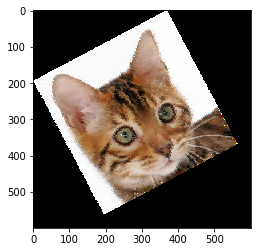

In [8]:
cat = np.array(mpimg.imread('part1/cat.jpg'))
cat.setflags(write=1)

cols = 600
rows = 600
M = rot(145)
cat_crop = cat[4:144,80:220]
cat_sol0_1 = warpPerspective(cat_crop,M,(cols,rows))
plt.imshow(cat_sol0_1)
plt.show()


# 2. Interpolation

At this point, you can predict that creating a large image from small image will not give us the best results, ie there will be a lot of empty pixel values. There are multiple ways to handle this, i.e. Bilinear Interpolation, Nearest, Bicubic etc. However, the method that we will be utilizing in this assignment is fairly simple. We will be replacing empty pixel values with the average of all pixel values around that pixel. Be careful, while handling the corner/side pixels of the image.



## Task 2.1


For this, we can augment your function `warpPerspective(img,M,(cols,rows))`.

1. Where you previously took the nearest neighbor to fill missing pixels, use the `Interpolation` algorithm. 
2. Input cols and rows values as 2000 and 2160
3. Use the same projective matrix
4. Display the output
    
the output should look similar to `part1/cat_sol1.jpg`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


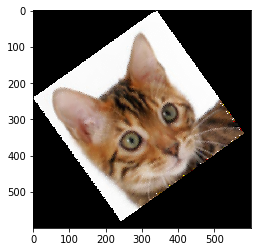

In [9]:
#TODO
M = rot(120) # your 3x3 matrix
cols = 600
rows = 600
cat_crop = cat[4:144,80:220]
cat_sol1 = warpPerspective(cat_crop,M,(cols,rows),True)

plt.imshow(cat_sol1)
plt.show()


# 3. Image Alpha Values



In this section we will be blending two images to create a third image. This process is important in applications such as VR, AR etc.

For this section, it is important to understand alpha values. Alpha values range between 0.0 and 1.0, and determine the transparency of a pixel. These are common in png files where they are stored alongside rgb as rgba. 

## Task 3.1

You must manipulate your `warpPerspective(img,M,(cols,rows))` function so that it returns values in the form of rgba. You can do this with the following steps: 

1. If the image has values in 8bit integers, convert your 0 - 255 color integer value range to 0.0 - 1.0 float. 
2. Append a forth pixel value for the alpha
3. It might be easier to create a seperate function that converts rgb to rgba with alpha values set to 1.0
4. Where you were previously setting the background to be black, also set the alpha to 0.0
    
The output from the previous test should look similar to `part1/cat_sol2.png`. you can explore the png file structure to get a better idea of the output. 




In [13]:
def warpPerspectiveA(img,M,dsize,linear_inter = False):
    height, width = img.shape[:2]
    tx, ty = np.array((width // 2, height // 2))
    T1 = trans(-tx,-ty)
    T1Inv = np.linalg.inv(T1)
    R1 = M
    S = scale(3,3)
    
    A = np.dot(T1Inv,np.dot(R1,np.dot(S,T1)))

    coords = homogenous(width,height)
    x_ori = coords[0].astype(np.int)

    y_ori = coords[1].astype(np.int)

    warped = np.dot(A,coords)

    x_warped = warped[0,:].reshape(1,-1)
    y_warped= warped[1,:].reshape(1,-1)
    x_min = np.min(x_warped)
    y_min = np.min(y_warped)
    if x_min >=0:
        x_min = 0
    if y_min >=0:
        y_min = 0

    T2 = np.linalg.inv(trans(x_min,y_min))
    warped = np.dot(T2,warped).astype(np.int)
    x_warped = warped[0,:]
    y_warped= warped[1,:]
    x_warped = list(np.ceil(x_warped).astype(np.int))
    y_warped = list(np.ceil(y_warped).astype(np.int))

    final = np.zeros([dsize[0],dsize[1],4],dtype=np.float64)
    
    
    warped = np.vstack((x_warped,y_warped)).astype(np.int)
    coords2 = np.vstack((coords[0],coords[1])).astype(np.int)
    for i in range(coords2.shape[1]):
        x_from,y_from = coords2[:,i]
        x_to,y_to = warped[:,i]
        rgb_from = img[x_from,y_from]
        rgb_from = rgb_from / 255
        
        rgb_from = np.append(rgb_from,1.0)
        
        final[x_to,y_to] = rgb_from 
        
        
    #Filling missing values
    
    final_homo = homogenous(dsize[0],dsize[1])
    final_homo = np.array(final_homo[0:2,:])
    
    min_x = np.min(warped[0])
    max_x = np.max(warped[0])
    min_y = np.min(warped[1])
    max_y = np.max(warped[1])
    
    
    if linear_inter == False:
        for i in range(final_homo.shape[1]):
            x,y = final_homo[:,i].astype(np.int)
            rgb = final[x,y]
            t_c = 0
            
            rgb_this = np.zeros_like(rgb)
            if rgb[0] == 0 and rgb[1] == 0 and rgb[2] == 0:
                if((x <= min_x or x >= max_x) or (y <= min_y or y >= max_y )):
                    continue
                else:
                    rgb_avg = np.zeros_like(rgb)
                
                    temp_warped = np.array((warped[0] == x))
                    all_x =warped[:,temp_warped]
                    if all_x.size == 0:    
                        continue
                        
                    minn_y = np.min(all_x[1])
                    maxx_y = np.max(all_x[1])
                    if y <= minn_y:
                        continue
                    elif y >= maxx_y:
                        continue
                    else:
                        
                        if (y < (max_y) and (x < (max_x)) and (x > 0) and (y > 0)):
                            
                            if final[x+1,y+1][0] != 0 and final[x+1,y+1][1] != 0 and final[x+1,y+1][2] != 0:
                                t_c+=1
                                rgb_this = final[x+1,y+1]

                            if final[x-1,y-1][0] != 0 and final[x-1,y-1][1] != 0 and final[x-1,y-1][2] != 0:
                                t_c+=1
                                rgb_this = final[x-1,y-1]     

                            if final[x-1,y][0] != 0 and final[x-1,y][1] != 0 and final[x-1,y][2] != 0:
                                t_c+=1
                                rgb_this = final[x-1,y]

                            if final[x,y-1][0] != 0 and final[x,y-1][1] != 0 and final[x,y-1][2] != 0:
                                t_c+=1
                                rgb_this = final[x,y-1]

                            if final[x+1,y][0] != 0 and final[x+1,y][1] != 0 and final[x+1,y][2] != 0:
                                t_c+=1
                                rgb_this = final[x+1,y]    
                            if final[x,y+1][0] != 0 and final[x,y+1][1] != 0 and final[x,y+1][2] != 0:
                                t_c+=1
                                rgb_this = final[x,y+1]

                            if t_c != 0:
                                
                                final[x,y] = rgb_this
                                
                                                    
            
    elif linear_inter == True:    
        for i in range(final_homo.shape[1]):
            x,y = final_homo[:,i].astype(np.int)
            rgb = final[x,y]
            t_c_r,t_c_g,t_c_b = 0,0,0
            if rgb[0] == 0 and rgb[1] == 0 and rgb[2]  == 0:
                
                if((x <= min_x or x >= max_x) or (y <= min_y or y >= max_y )):
                    continue
                else:
                    rgb_avg = np.zeros_like(rgb)
                    rgb_avg[3] = 1
                    temp_warped = np.array((warped[0] == x))
                    all_x =warped[:,temp_warped]
                    if all_x.size == 0:    
                        continue
                        
                    minn_y = np.min(all_x[1])
                    maxx_y = np.max(all_x[1])
                    if y < minn_y:
                        continue
                    elif y > maxx_y:
                        continue
                    else:
                        if ((x > min_x and y> min_y) & (x< (max_x)) and (y < (max_y))): 
                            xx,yy = x-1, y-1
                            for i in range(3):
                                for j in range(3):
                                    rgb_check = final[xx+i,yy+j]
                                    if rgb_check[0] >= 0.00001:    
                                        t_c_r+=1
                                        rgb_avg[0] += rgb_check[0]
                                    if rgb_check[1] >= 0.00001:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 0.00001:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            
                            
                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] / t_c_r
                                
                                final[x,y][0] = rgb_avg[0]
                                
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] / t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] / t_c_b
                                final[x,y][2] = rgb_avg[2] 
                            final[x,y][3] = 1   
                                
                        
                        elif (x == 0 and y == 0):
                            xx, yy = x,y
                            for i in range(2):
                                for j in range(2):
                                    rgb_check = final[xx+i,yy+j]
                                    if rgb_check[1] >= 0.00001:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 0.00001:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]
                            final[x,y][3] = 1     

                        
                        
                        elif (x > min_x and (x < max_x) and y == min_y ):
                            
                            xx, yy = x,y-1
                            for i in range(3):
                                for j in range(3):

                                    rgb_check = final[xx+i,yy+j]
                                    if rgb_check[1] >= 0.00001:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 0.00001:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]            
                            final[x,y][3] = 1 


                        elif ((x == min_x  and (y == max_y))):
                            xx, yy = x,y-1
                            for i in range(2):
                                for j in range(2):

                                    rgb_check = final[xx+i,yy+j]
                                    if rgb_check[1] >= 0.00001:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 0.00001:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]

                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]   
                            final[x,y][3] = 1 



                        elif ((x == min_x) and y == min_y):
                        
                            xx, yy = x-1,y
                            for i in range(2):
                                for j in range(2):

                                    rgb_check = final[xx+i,yy+j]

                                    if rgb_check[1] >= 0.00001:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 0.00001:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                                    
                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]  
                            final[x,y][3] = 1 



                        elif (x > min_x and (x < max_x) and y == min_y):
                            
                            xx, yy = x,y-1
                            for i in range(2):
                                for j in range(3):
                                    
                                    rgb_check = final[xx+i,yy+j]

                                    if rgb_check[1] >= 0.00001:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 0.00001:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                                
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]   
                            final[x,y][3] = 1 

                       

                        elif (x > min_x and (x < max_x) and (y == (max_y))):
                            
                            xx, yy = x-1,y-1
                            for i in range(3):
                                for j in range(2):

                                    rgb_check = final[xx+i,yy+j]

                                    if rgb_check[1] >= 0.00001:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 0.00001:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                            
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]            
                            final[x,y][3] = 1 
                        elif ((x == max_x) and (y > 0) & (y < max_y) ):
                        
                            xx, yy = x-1,y-1
                            for i in range(2):
                                for j in range(3):
                                    rgb_check = final[xx+i,yy+j]

                                    if rgb_check[1] >= 0.00001:
                                        t_c_g+=1
                                        rgb_avg[1] += rgb_check[1]                                   
                                    if rgb_check[2] >= 0.00001:
                                        t_c_b+=1
                                        rgb_avg[2] += rgb_check[2]
                            if t_c_r >= 1:
                                rgb_avg[0] = rgb_avg[0] // t_c_r
                                final[x,y][0] = rgb_avg[0]
                            if t_c_g >= 1:
                                rgb_avg[1] = rgb_avg[1] // t_c_g
                                final[x,y][1] = rgb_avg[1]
                            if t_c_b >= 1:
                                rgb_avg[2] = rgb_avg[2] // t_c_b
                                final[x,y][2] = rgb_avg[2]
                            final[x,y][3] = 1  
                                
    for i in range(final_homo.shape[1]):
        x,y = final_homo[:,i].astype(np.int)
        rgb = final[x,y]
        if ((x > min_x and y> min_y) & (x< (max_x)) and (y < (max_y))): 
            t_c_r,t_c_g,t_c_b = 0,0,0
            if rgb[0] == 0 and rgb[1] == 0 and rgb[2]  == 0:
                xx,yy = x-1, y-1
                for i in range(3):
                    for j in range(3):
                        rgb_check = final[xx+i,yy+j]
                        if rgb_check[0] >= 40:
                            t_c_r+=1
                            rgb_avg[0] += rgb_check[0]

                        if rgb_check[1] >= 40:
                            t_c_g+=1
                            rgb_avg[1] += rgb_check[1]                                   
                        if rgb_check[2] >= 40:
                            t_c_b+=1
                            rgb_avg[2] += rgb_check[2]

                if t_c_r >= 5:

                    rgb_avg[0] = rgb_avg[0] // t_c_r
                    final[x,y][0] = rgb_avg[0]
                if t_c_g >= 5:
                    rgb_avg[1] = rgb_avg[1] // t_c_g
                    final[x,y][1] = rgb_avg[1]
                if t_c_b >= 5:
                    rgb_avg[2] = rgb_avg[2] // t_c_b
                    final[x,y][2] = rgb_avg[2] 
    return final

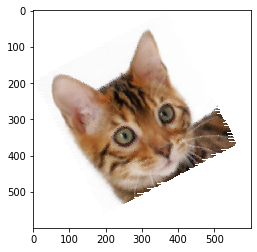

In [14]:
#TODO
M = rot(145) # your 3x3 matrix
cols = 600
rows = 600
cat_sol2 = warpPerspectiveA(cat_crop,M,(cols,rows),True)

plt.imshow(cat_sol2)

# 4. Cricket Stadium

In this part we will be adding an image of a cricket scoreboard to a cricket stadium.



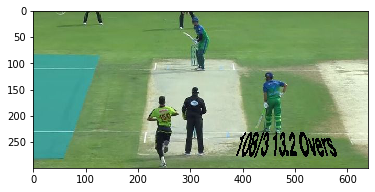

In [6]:
# Your final output should look similar to the below given image i.e. stadium-sol5.jpg
stadium = np.array(mpimg.imread('stadium-sol5.jpg'))
stadium.setflags(write=1)
plt.imshow(stadium)


## Task 4.1

For this task, you need to transform the given scoreboard image. Your output should look similar to `transformed-scoreboard.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those.

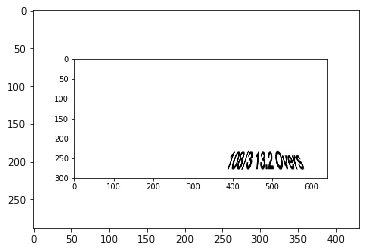

In [7]:
# transformed-scoreboard.jpg
board = np.array(mpimg.imread('transformed-scoreboard.jpg'))
board.setflags(write=1)
plt.imshow(board)


(46, 288, 3)

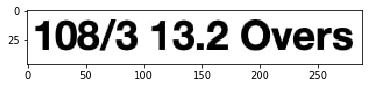

In [24]:
# start your code here
score = np.array(mpimg.imread('score.jpg'))
score.setflags(write=1)
plt.imshow(score)
score.shape


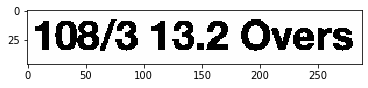

In [26]:
score_copy = np.full((46,288,3),255).astype(np.int)
width, height = 46,288
lst = [1,1,1]
lst_1 = [254,254,254]
coords_1 = homogenous(width,height)
coords_2 = np.vstack((coords_1[0],coords_1[1])).astype(np.int)
count = 0
for i in range(coords_2.shape[1]):
    x,y = coords_2[:,i]
    rgb_this = score[x,y]
    
    if rgb_this[0] < 150 and rgb_this[1] < 150 and rgb_this[2] < 150:
        rgb_this = lst
        homo[x,y] = rgb_this
    else:
        rgb_this = lst_1 
        score_copy[x,y] = rgb_this
        
    
    
    
       
        
    

plt.imshow(score_copy)   
plt.savefig('BLACK.jpg',bbox_inches='tight')
    

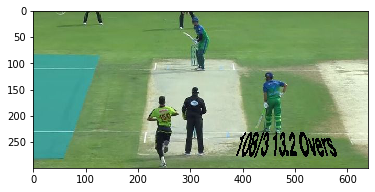

In [10]:
plt.imshow(stadium)

In [20]:
T1 = trans(0,0)
S1 = scale(0,0)
SH1 = shear(0)
warped = np.dot(T1,np.dot(SH1,np.dot(S1,coords_1)))
warped = np.vstack((warped[0],warped[1])).astype(np.int)

In [23]:
homo = np.array(mpimg.imread('HOMO.jpg'))
homo.shape

(71, 270, 3)

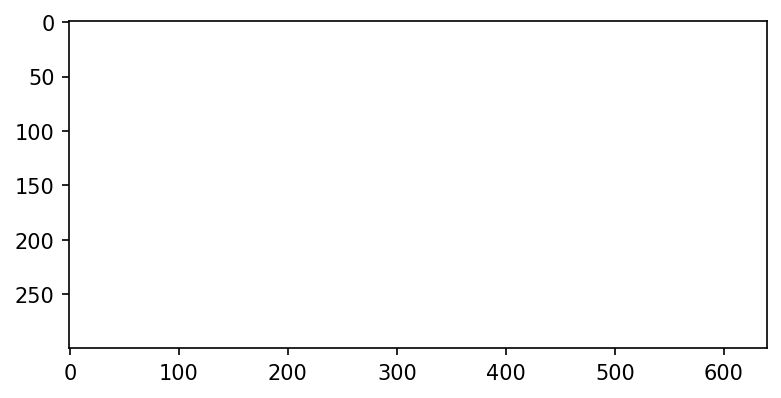

In [27]:

stadium_big = np.full((300,640,3),255,dtype=np.int)
stadium_homo = homogenous(300,640)
stadium_homo = np.vstack((stadium_homo[0],stadium_homo[1]))
ls = [0,0,0]
ls_w = [255,255,255]
for i in range(coords_2.shape[1]):
    x_from,y_from = coords_2[:,i]
    rgb_from = score_copy[x_from,y_from]
    x_to,y_to = warped[:,i]
    stadium_big[x_to,y_to] = rgb_from
    
    
min_x = np.min(warped[0])
max_x = np.max(warped[0])
min_y = np.min(warped[1])
max_y = np.max(warped[1])


for i in range( stadium_homo.shape[1]):
    x,y =  stadium_homo[:,i].astype(np.int)
    rgb = stadium_big[x,y]
    rgb_this = np.zeros_like(rgb)
    if rgb[0] == 255 and rgb[1] == 255 and rgb[2] == 255:
        
        if((x <= min_x or x >= max_x) or (y <= min_y or y >= max_y )):
            
            continue
        else: 
            if stadium_big[x+1,y][0] != 0 and stadium_big[x+1,y][1] != 0 and stadium_big[x+1,y][2] != 0:
                rgb_this = stadium_big[x+1,y]  
                stadium_big[x,y] = rgb_this    

            elif stadium_big[x-1,y][0] != 0 and stadium_big[x-1,y][1] != 0 and stadium_big[x-1,y][2] != 0:
                rgb_this = stadium_big[x-1,y]  
                stadium_big[x,y] = rgb_this    
              

            
for i in range( stadium_homo.shape[1]):
    x,y =  stadium_homo[:,i].astype(np.int)
    rgb = stadium_big[x,y]
    if rgb[0] == 1 and rgb[1] == 1 and rgb[2] == 1:
        rgb = ls
    else:
        rgb = ls_w
    
    stadium_big[x,y] = rgb
    


figure(dpi=150)
plt.imshow(stadium_big)

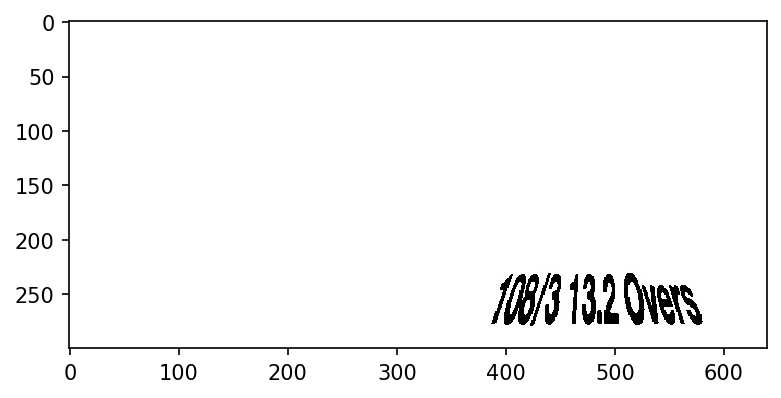

In [53]:
score_mask = np.array(mpimg.imread('score_mask.jpg'))
score_homo = homogenous(300,640)


score_homo = np.array(score_homo[0:2,:])
for i in range(score_homo.shape[1]):
    x,y = score_homo[:,i].astype(np.int)
    rgb = score_mask[x,y] 
    
    rgb[0] = np.abs(rgb[0]-255)
    rgb[1] = np.abs(rgb[1]-255)
    rgb[2] = np.abs(rgb[2]-255)
    
    score_mask[x,y] = rgb
    
figure(dpi=150)
plt.imshow(score_mask)


In [ ]:

    im_src = cv2.imread('FO.png')
    # Four corners of the book in source image
    pts_src = np.array([[7, 34], [176, 33], [174, 11],[33, 14]])
 
 
    # Read destination image.
    im_dst = cv2.imread('FL.png')
    # Four corners of the book in destination image.
    pts_dst = np.array([[2, 43],[157, 43],[144, 13],[31, 16]])
 
    # Calculate Homography
    h, status = cv2.findHomography(pts_src, pts_dst)
     
    # Warp source image to destination based on homography
    im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
     
    # Display images
    cv2.imshow("Source Image", im_src)
    cv2.imshow("Destination Image", im_dst)
    cv2.imshow("Warped Source Image", im_out)
 
    cv2.waitKey(0)

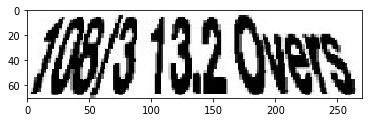

In [4]:
# CONVERT BACK TO WHITE/BLACK
homography_img = np.array(mpimg.imread('HOMO.jpg'))
 

plt.imshow(homography_img)   

# USED IN THE BEINNING

## Task 4.2

After you have transformed the scorebaord you have to add it to the given stadium image. This can be done by copying pixel values from the transformed scoreboard image to the given stadium image. You need to figure out the appropriate conditions for copying the pixel values. 

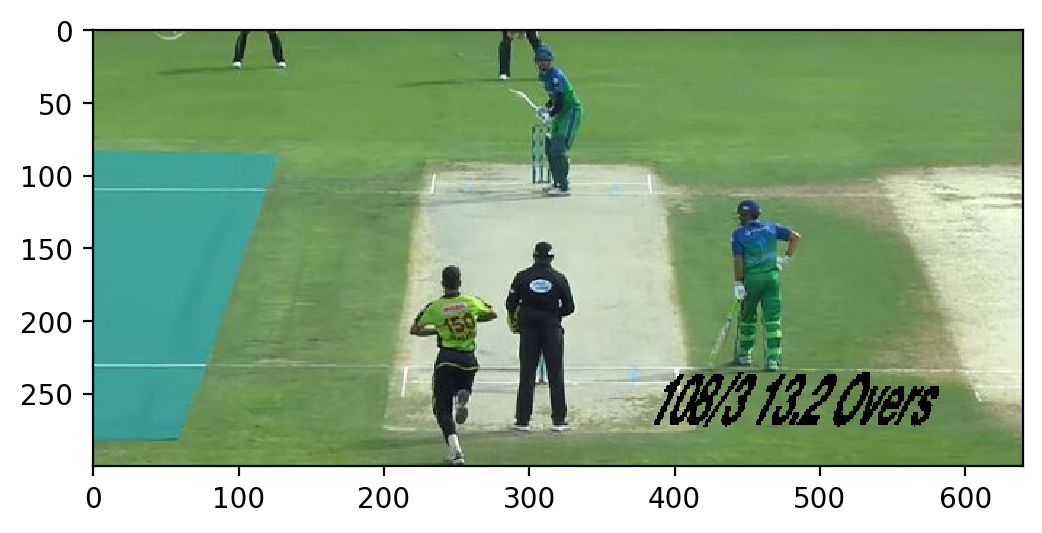

In [17]:
ground_og = np.array(mpimg.imread('PSL-Stadium.jpg'))
                     
for i in range(stadium_homo.shape[1]):
    x,y = stadium_homo[:,i].astype(np.int)
    rgb = stadium_big[x,y]
    
    if rgb[0] <= 40 and rgb[1] <= 40 and rgb[2] <= 40:
        
        
        ground_og[x,y] = rgb
figure(dpi=200)    
plt.imshow(ground_og)    
                           

## Task 4.3

In certain situations, when we want to isolate a subject in an image, alpha masks are provided to us. Alpha masks describe the transparency of an image. These masks can be in any format ranging from jpg, png, bmp, gif,etc in our example we will be using jpg.

For this part we will reproduce the same solution but by using alpha mask this time. Below you are given an alpha mask for the transfomed scoreboard. Using this alpha mask you need to combine the two images together to produce the same output.

You can achieve the desired solution as follows:

Consider the transformed scoreboard image as the foreground image and the stadium image as the background image. At every pixel of the image, we need to combine the foreground image pixel value with the background image pixel value using the alpha mask.

 
\begin{align*}
T = \alpha*F+(1-\alpha)B
\end{align*}

1. Where T is target pixel value
2. F is the pixel value in the foreground image
3. B is the pixel value of the background image
4. Alpha is value of the alpha mask for the corresponding pixels

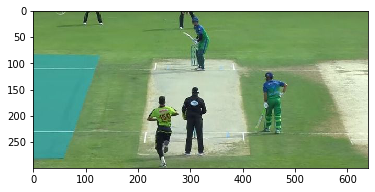

In [79]:
# score-mask.jpg
ground_og2 = np.array(mpimg.imread('PSL-Stadium.jpg'))

score_mask = np.array(mpimg.imread('score_mask.jpg'))
final = np.zeros_like(ground_og2)

score_homo = homogenous(300,640)

score_homo = np.array(score_homo[0:2,:])
for i in range(score_homo.shape[1]):
    x,y = score_homo[:,i].astype(np.int)
    rgb = score_mask[x,y] 
    
    rgb[0] = np.abs(rgb[0]-255)
    rgb[1] = np.abs(rgb[1]-255)
    rgb[2] = np.abs(rgb[2]-255)
    
    score_mask[x,y] = rgb
    



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


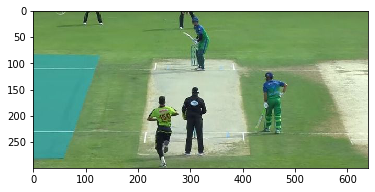

In [81]:
#Alpha Mask Image

alpha_mask = np.full((score_mask.shape[0],score_mask.shape[1],4),255).astype(np.float64)
plt.imshow(alpha_mask)
for i in range(score_homo.shape[1]):
    x,y = score_homo[:,i].astype(np.int)
    rgb = score_mask[x,y]
    if rgb[0] <= 70 and rgb[1] <= 70 and rgb[2] <= 70:
        rgb = rgb / 255
        rgb = np.append(rgb,1)
    else:
        
        rgb = rgb / 255
       
        rgb = np.append(rgb,0)
        
    
    alpha_mask[x,y] = rgb
    
plt.imshow(ground_og2)  

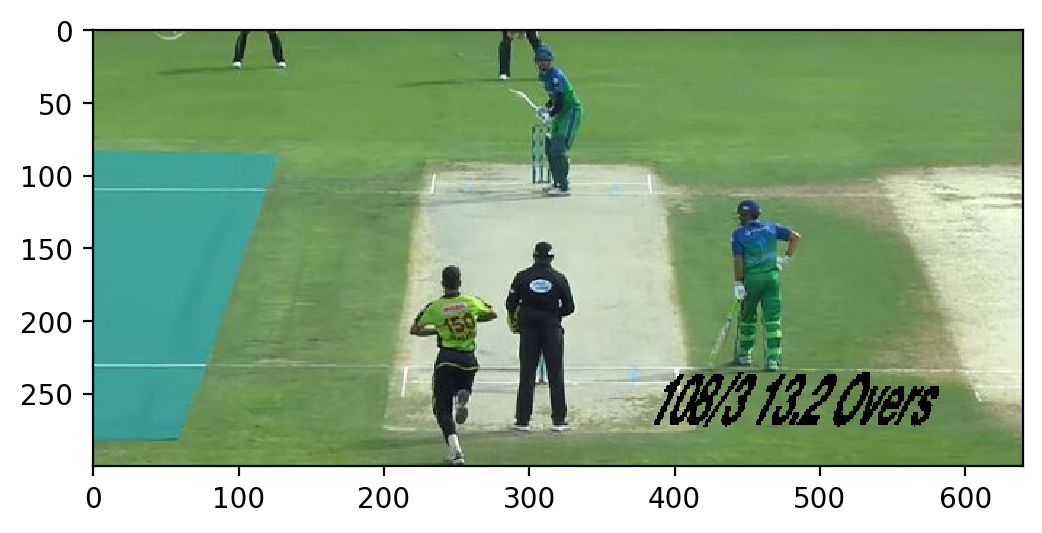

In [90]:


final = np.zeros_like(ground_og2)

ground_homo = homogenous(300,640)

ground_homo = np.array(stadium_homo[0:2,:])


for i in range(ground_homo.shape[1]):
    x,y = ground_homo[:,i].astype(np.int)
    rgb_g =ground_og2[x,y]
    rgb_s = (score_mask[x,y])
    rgb_alpha = alpha_mask[x,y][3]
    
    rgb = np.zeros_like(rgb_s) 
   
    rgb = rgb_alpha*(rgb_s) + (1-rgb_alpha)*(rgb_g)  
    final[x,y] = rgb
    
figure(dpi=200)
plt.imshow(final)   
plt.imshow(ground_og)    

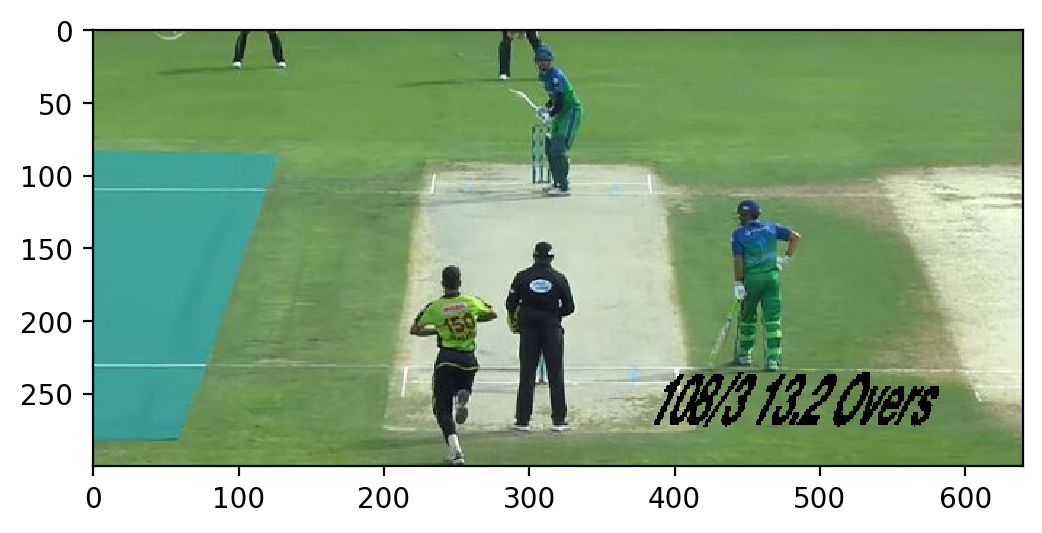

In [91]:
figure(dpi=200)
plt.imshow(ground_og) 

# 5. Solar System (CS5310, EE513 Only, Upto 10 marks bonus for CS436)

![alt Solar System demo](https://drive.google.com/uc?id=10xxjq46hha2HS0xjyaqM-iwgrMg01d6w)

In [20]:
height = width = 1500 # shape of canvas

## Task 5.1
In this task you will try to recreate the above gif by making use of all the previously implemented techniques.

Your first task is to import the image of planet earth and apply appropriate transformations to center it within the canvas. 

You are allowed to import opencv and make use of cv2.warpPerspective(sun,M,(width, height)) 



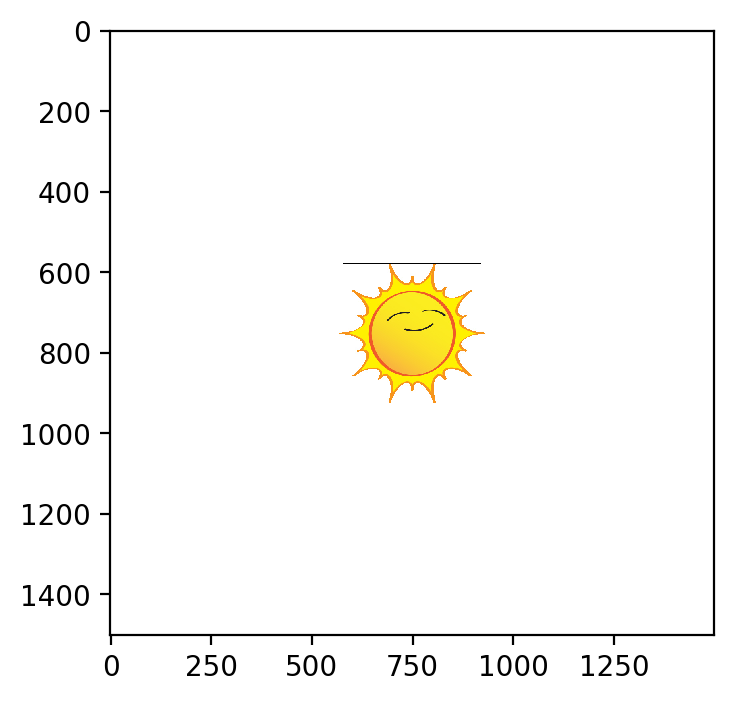

In [21]:
# Import sun.jpg and apply appropriate transformations to center the image
sun = np.array(mpimg.imread('sun.jpg'))
x,y = sun.shape[:2]

tx = x//2
ty = y//2
T1 = trans(-tx,-ty)
T2 = trans(750,750)


sun_center = np.full((1500,1500,3),255)
coords_s_1 = homogenous(345,365)
coords_s_2 = np.vstack((coords_s_1[0],coords_s_1[1])).astype(np.int)


warped = np.dot(T2,np.dot(T1,coords_s_1))
y_min = np.min(warped[1].astype(np.int)) + 10
x_min = (np.min(warped[0]).astype(np.int))
x_max = (np.max(warped[0]).astype(np.int))
diff=  x_max-x_min

warped = np.vstack((warped[0],warped[1])).astype(np.int)


for i in range(coords_s_2.shape[1]):
    x,y = coords_s_2[:,i]
    rgb_from = sun[x,y]
    x_to,y_to = warped[:,i]
    
    sun_center[x_to,y_to] = rgb_from
for j in range(3):
    for i in range(diff):
        sun_center[y_min-j,x_min+i][0] = 0
        sun_center[y_min-j,x_min+i][1] = 0
        sun_center[y_min-j,x_min+i][2] = 0
        
    
figure(dpi = 200)
plt.imshow(sun_center)

Your result should look like (It does not matter whether the background is black or white)

Note: The resulting canvas has height and width of 1500px

![alt Sun Result](https://drive.google.com/uc?id=1IdYgql7RFwvXT1SxwuBRkW3AMKdZeexg)

## Task 5.2
In this part, you will carry out the same process for earth.jpg as well. Except, in this case the earth needs to be translated +400px on the y axis.

250 250


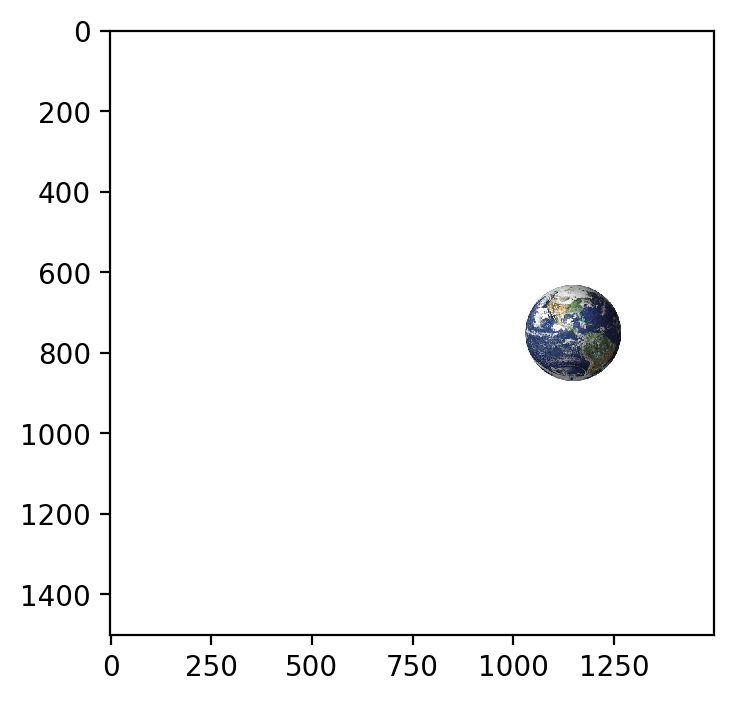

In [22]:
earth = np.array(mpimg.imread('earth.jpg'))
x,y = earth.shape[:2]
print(x,y)
tx = x//2
ty = y//2
T1 = trans(-tx,-ty+400)
T2 = trans(750,750)


earth_center = np.full((1500,1500,3),255).astype(np.uint8)
coords_s_1 = homogenous(x,y)
coords_s_2 = np.vstack((coords_s_1[0],coords_s_1[1])).astype(np.int)


warped = np.dot(T2,np.dot(T1,coords_s_1))
warped = np.vstack((warped[0],warped[1])).astype(np.int)


for i in range(coords_s_2.shape[1]):
    x,y = coords_s_2[:,i]
    rgb_from = earth[x,y]
    x_to,y_to = warped[:,i]
    
    earth_center[x_to,y_to] = rgb_from
figure(dpi=200)    
plt.imshow(earth_center)    

Your final image should look something like this

![alt Result earth](https://drive.google.com/uc?id=16eFaOHVlhUKgHpw8ZVCwSvzagJcD_s8K)

## Task 5.3
You will now modify the above code to apply rotations to the earth as such it rotates along its own axis as well as around the sun. (This is same as the problem given to you in your written assignment 1)

Feel free to copy your code from task 5.2

In [23]:
def earth_func(earth,hour):
        
        angle = np.divide(np.multiply(hour,360),24)
        S1 = 1.0
        (height, width) = earth.shape[:2]
        dims = [1500,1500]
        right_tr = (1500 // 2) + 400
        left_tr =   (1500//2 )
        mid_point = (right_tr,left_tr)
        
        M = cv2.getRotationMatrix2D(mid_point,angle,S1)
        earth_ = cv2.warpAffine(earth, M, (1500,1500))
        
        earth=earth_
  
        total_hrs = np.multiply(365,24)
        angle = np.divide(np.multiply(hour,360),total_hrs)
        (h, w) = earth.shape[:2]
        mid_2 = (w / 2, h / 2)
        M = cv2.getRotationMatrix2D(mid_2, angle, S1)

        earth_ = cv2.warpAffine(earth, M,  (1500,1500))
        
        
        earth_[np.where((earth_==[0,0,0]).all(axis=2))] = [255,255,255]
        return earth_

In [24]:
earths = []
for x in range(30):
  earths.append(earth_func(earth_center,x*10))


## Task 5.4
You will now blend all three images to compose a single image. Feel free to make use of the canvas below.

You will have to traverse every element of the list (earths) and blend them with the transformed sun image created in task 5.1. After doing this, you will get an array of images in the end with each having a sun and a earth in them. Store this array in the variable final and run the code gif builder code in the end

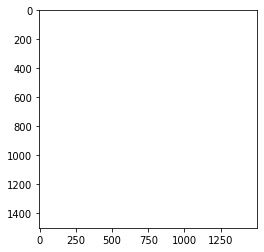

In [25]:
canvas = np.array([255]*3*1500*1500)
canvas.resize((1500,1500,3))
plt.imshow(canvas)

In [26]:
final = []

for val in range(len(earths)):
    canvas = np.array([255]*3*1500*1500)
    canvas.resize((1500,1500,3))
    for k in range(sun_center.shape[0]):
        for j in range(sun_center.shape[1]):
            rgb = sun_center[k,j]
            if rgb[0] !=255 and rgb[1]!=255 and rgb[2]!=255:
                canvas[k,j]=sun_center[k,j]
            earth_temp =earths[val]
            rgb_this = earth_temp[k,j]
            if rgb_this[0]!=255 and  rgb_this[1]!=255 and rgb_this[2]!=255:
                canvas[k,j]=earth_temp[k][j]
    final.append(canvas)
    


Please submit movie.gif along with the jupyter notebook

In [27]:
for i in range(len(final)):
    print(i)
    final[i]=final[i].astype(np.uint8)

imageio.mimsave('movie_200.gif', final)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


# Submission Instructions

You are required to submit the CV_PA1 Jupyter file and Part-5 gif only via LMS. Rename CV_PA1 to CV_PA1_[your rollnumber]. 

The submitted file should be in a readable and understandable format. Add as many comments as possible. It should run from start to end without any errors. It must be in Python3.

The notebook "CV_PA1_intro" will help you get started with image manipulation. If you are familiar with it, skip it.
